# BCI transfer learning algorithm implementation

This notebook contains tests of multi-task learning algorithm described in <a href="https://ieeexplore.ieee.org/document/7379089">Transfer Learning in Brain-Computer Interfaces</a> referenced here as **Algorithm 1**. My implementation is based on source code that can be found <a  href="https://github.com/vinay-jayaram/MTlearning/blob/master/MT_linear.m">here</a>.  
An upgrade of Algorithm 1 described in <a href="https://link.springer.com/article/10.1007/s11517-020-02176-y">EEG classification across sessions and across subjects through transfer learning in motor imagery-based brain-machine interface system</a> referenced as **Algorithm 2**, is also tested here.  
The dataset used for testing is BCI Competition IV 2a.


# Imports and environment


In [1]:
import sys
import os
import warnings
import mne

warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
mne.set_config("MNE_DATA", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_BNCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_EEGBCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MOABB_RESULTS", os.path.join(os.getcwd(), "results"))
os.makedirs(os.environ["MNE_DATA"], exist_ok=True)
os.makedirs(os.environ["MOABB_RESULTS"], exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from importlib import reload
from mne.decoding import CSP, PSDEstimator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import scripts.multi_task.linear as linear
import scripts.multi_task.linear_data_selection as linear_ds
from scripts.features_extract.welch import extract_welch_features
from eeg_logger import logger

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")

# Instantiate dataset

**Datased used is BCI Competition IVa**


In [2]:
dataset = BNCI2014_001()
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
paradigm = LeftRightImagery(channels=None)
data = dataset.get_data(subjects=[1])
data[1]["0train"]["0"]

<RawArray | 26 x 96735 (386.9 s), ~19.2 MiB, data loaded>

# Create pipelines for SVM and LDA

**1** - CSP + SVM  
**2** - PSD + LDA

These classifiers are used for comparison.


In [3]:
pipelines = {
    "csp+svm": make_pipeline(CSP(n_components=6), SVC(kernel="linear")),
    "psd+lda": make_pipeline(
        PSDEstimator(fmin=7, fmax=31, sfreq=250),
        FunctionTransformer(lambda X: X.reshape(X.shape[0], -1)),
        LDA(),
    ),
}

# Evaluate


In [ ]:
evaluation = CrossSessionEvaluation(paradigm=paradigm, datasets=[dataset], overwrite=True)
results = evaluation.process(pipelines)
results = results[results["session"] == "1test"]
results

# Plot SVM and LDA classifier results


(0.5, 1.0)

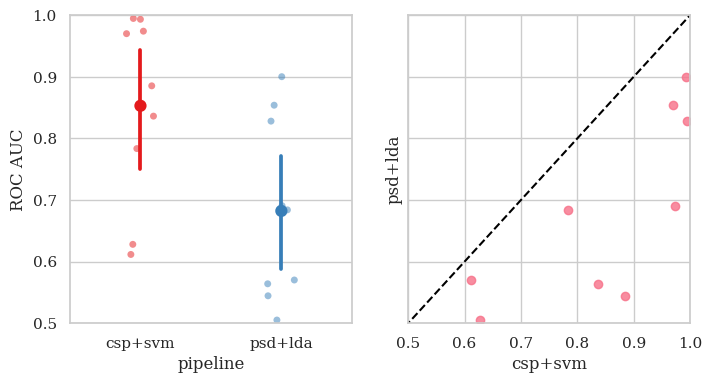

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=axes[0], palette="Set1")

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.5, 1)

paired = results.pivot_table(values="score", columns="pipeline", index=["subject", "session"])
paired = paired.reset_index()

sns.regplot(data=paired, y="psd+lda", x="csp+svm", ax=axes[1], fit_reg=False)
axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.5, 1)

# Prepare train and test data

The data is organised as follows:

- **X_all** - all data from epochs regarding left/right hand movement
- **y_all** - all labels from epochs regarding left/right hand movement
- **X_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (2, ) representing first session of each subject split in half
- **y_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (2, ) representing labels of first session for each subject (split in half)
- **X_test** - array of shape (n_subjects, ) where each element represents data from the second session of each subject
- **y_test** - array of shape (n_subjects, ) where each element represents labels from the second session of each subject


In [3]:
X_all, y_all, metadata = paradigm.get_data(dataset, subjects=dataset.subject_list, return_epochs=False)
subjects = metadata["subject"].unique()
sessions = metadata["session"].unique()

X_train = np.empty(len(subjects), dtype=object)
X_test = np.empty(len(subjects), dtype=object)
y_train = np.empty(len(subjects), dtype=object)
y_test = np.empty(len(subjects), dtype=object)
label_map = {"left_hand": 1, "right_hand": -1}

for idx, subject in enumerate(subjects):

    sess_1_mask = (metadata["subject"] == subject) & (metadata["session"] == "0train")
    sess_2_mask = (metadata["subject"] == subject) & (metadata["session"] == "1test")

    X_sess_1 = X_all[sess_1_mask]
    y_sess_1 = y_all[sess_1_mask]
    X_sess_2 = X_all[sess_2_mask]
    y_sess_2 = y_all[sess_2_mask]

    X_sess_1_feat = extract_welch_features(X_sess_1)
    y_sess_1 = np.array([label_map[label] for label in y_sess_1])
    X_sess_2_feat = extract_welch_features(X_sess_2)
    y_sess_2 = np.array([label_map[label] for label in y_sess_2])

    X_subject_train = np.empty(2, dtype=object)
    X_subject_train[0] = X_sess_1_feat[:72].T
    X_subject_train[1] = X_sess_1_feat[72:].T
    y_subject_train = np.empty(2, dtype=object)
    y_subject_train[0] = y_sess_1[:72].reshape(-1, 1)
    y_subject_train[1] = y_sess_1[72:].reshape(-1, 1)

    X_train[idx] = X_subject_train
    y_train[idx] = y_subject_train
    X_test[idx] = X_sess_2_feat.T
    y_test[idx] = y_sess_2.reshape(-1, 1)

2025-09-06 13:41:14,424 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:15,345 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:16,267 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:17,169 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:18,089 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:18,982 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:19,872 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:20,757 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:21,654 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:22,533 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:23,436 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-09-06 13:41:24,327 - INFO - Welch features extrac

# Testing classifier across sessions (Algorithm 1)

First, classifier learns basic prior info based on first session of current patient.  
This creates a shared model with prior info.  
Then shared model is tested on second session of current patient.


In [4]:
accuracies = []
algorithm_1_results = {"subjects": subjects}

for idx, subject in enumerate(subjects):
    clf = linear.MultiTaskLinearClassifier(regularization=0.1, zero_mean=False, cov_flag="l1", verbose=False)
    clf.fit_sessions(X_train[idx], y_train[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])
    accuracies.append(acc * 100)
    algorithm_1_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_1_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")

logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_1_results["accuracies"] = accuracies

2025-09-06 13:42:00,375 - INFO - Accuracy for subject 0: 0.70
2025-09-06 13:42:12,594 - INFO - Accuracy for subject 1: 0.56
2025-09-06 13:42:24,462 - INFO - Accuracy for subject 2: 0.83
2025-09-06 13:42:36,657 - INFO - Accuracy for subject 3: 0.69
2025-09-06 13:42:51,146 - INFO - Accuracy for subject 4: 0.58
2025-09-06 13:43:05,617 - INFO - Accuracy for subject 5: 0.63
2025-09-06 13:43:21,169 - INFO - Accuracy for subject 6: 0.59
2025-09-06 13:43:35,586 - INFO - Accuracy for subject 7: 0.89
2025-09-06 13:43:50,883 - INFO - Accuracy for subject 8: 0.71
2025-09-06 13:43:50,883 - INFO - Mean accuracy across subjects: 68.67


# Plot results (Algorithm 1)


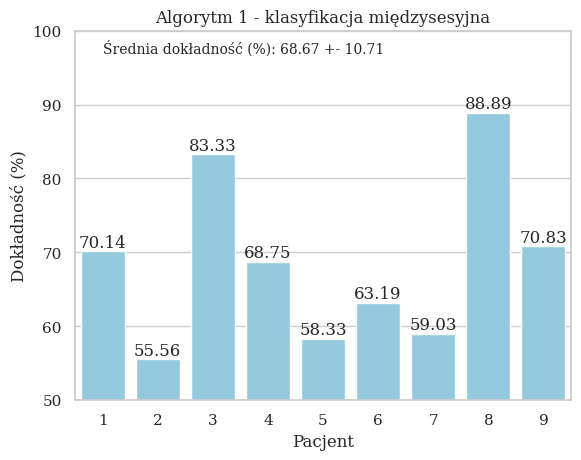

In [5]:
axes = sns.barplot(data=algorithm_1_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(50, 100)
axes.bar_label(axes.containers[0], fmt="%.2f", fontsize=12)
axes.set_title(f"Algorytm 1 - klasyfikacja międzysesyjna")
plt.text(
    x=0,
    y=97,
    s=f"Średnia dokładność (%): {np.mean(algorithm_1_results['accuracies']):.2f} +- {np.std(algorithm_1_results['accuracies']):.2f}",
    fontsize=10,
)
axes.set_ylabel("Dokładność (%)")
axes.set_xlabel("Pacjent")
plt.show()

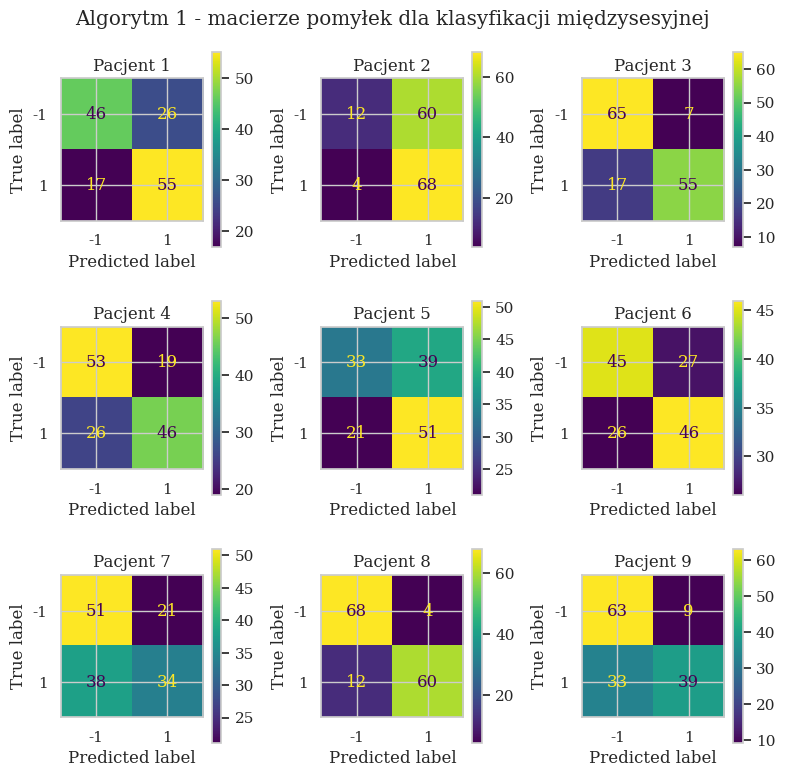

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i, subj_idx in enumerate(subjects):
    test = algorithm_1_results[f"subj_{subj_idx}_test_labels"]
    pred = algorithm_1_results[f"subj_{subj_idx}_pred_labels"]
    cm = confusion_matrix(test, pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
    disp.plot(ax=axes[i], values_format="d")
    axes[i].set_title(f"Pacjent {subj_idx}")
fig.suptitle("Algorytm 1 - macierze pomyłek dla klasyfikacji międzysesyjnej")
plt.tight_layout()

# Testing classifier across sessions (Algorithm 2)

First, shared model is acquired the same way as for previous testing pipeline.  
The train data is used to calculate weight vector for this task and select prior vectors that match the new vector the most.


In [7]:
accuracies = []
algorithm_2_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):

    clf = linear_ds.MultiTaskLinearWithSelectionClassifier(
        regularization=0.1, zero_mean=False, cov_flag="l1", verbose=False
    )
    clf.fit_sessions_with_selection(X_train[idx], y_train[idx], X_test[idx], y_test[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])

    accuracies.append(acc * 100)
    algorithm_2_results[f"subj_{idx + 1}_test_labels"] = y_test[idx]
    algorithm_2_results[f"subj_{idx + 1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_2_results["accuracies"] = accuracies

2025-09-06 13:44:45,352 - INFO - Accuracy for subject 0: 0.70
2025-09-06 13:44:57,731 - INFO - Accuracy for subject 1: 0.56
2025-09-06 13:45:10,438 - INFO - Accuracy for subject 2: 0.83
2025-09-06 13:45:27,733 - INFO - Accuracy for subject 3: 0.69
2025-09-06 13:45:44,931 - INFO - Accuracy for subject 4: 0.58
2025-09-06 13:46:00,985 - INFO - Accuracy for subject 5: 0.63
2025-09-06 13:46:17,531 - INFO - Accuracy for subject 6: 0.59
2025-09-06 13:46:33,128 - INFO - Accuracy for subject 7: 0.89
2025-09-06 13:46:59,429 - INFO - Accuracy for subject 8: 0.71
2025-09-06 13:46:59,429 - INFO - Mean accuracy across subjects: 68.67


# Plot results (Algorithm 2)


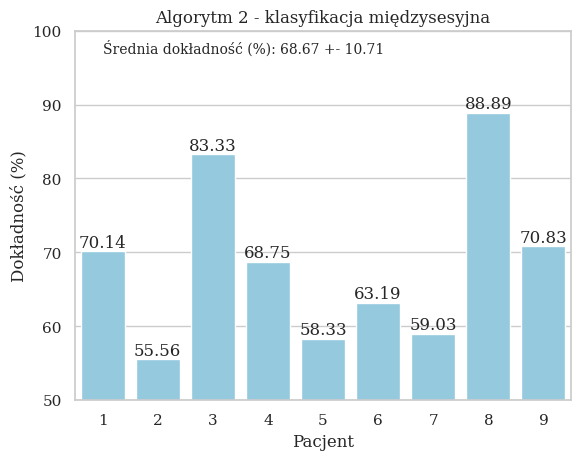

In [8]:
axes = sns.barplot(data=algorithm_2_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(50, 100)
axes.bar_label(axes.containers[0], fmt="%.2f", fontsize=12)
axes.set_title(f"Algorytm 2 - klasyfikacja międzysesyjna")
plt.text(
    x=0,
    y=97,
    s=f"Średnia dokładność (%): {np.mean(algorithm_2_results['accuracies']):.2f} +- {np.std(algorithm_2_results['accuracies']):.2f}",
    fontsize=10,
)
axes.set_ylabel("Dokładność (%)")
axes.set_xlabel("Pacjent")
plt.show()

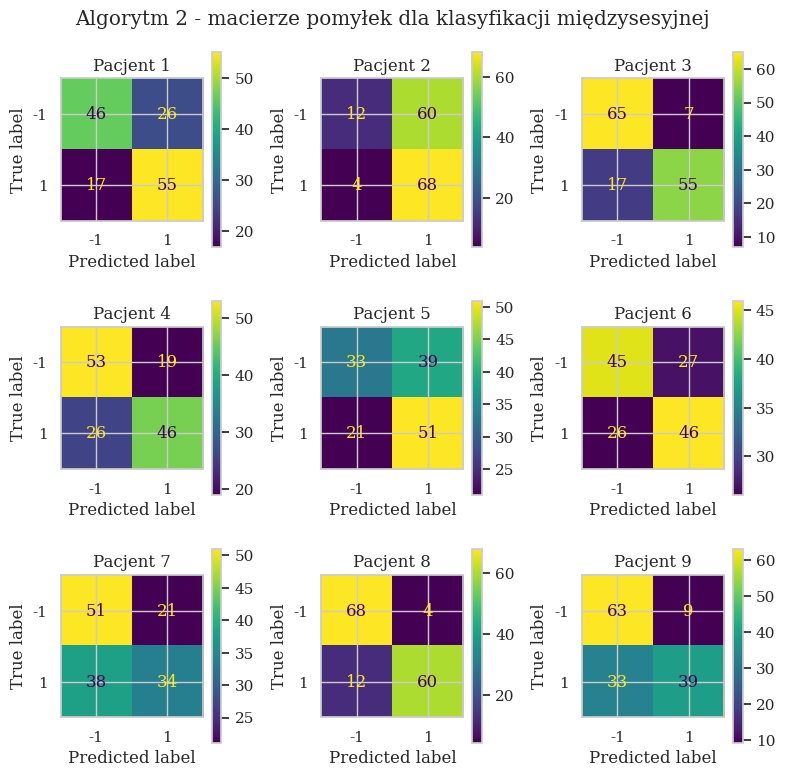

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i, subj_idx in enumerate(subjects):
    test = algorithm_1_results[f"subj_{subj_idx}_test_labels"]
    pred = algorithm_1_results[f"subj_{subj_idx}_pred_labels"]
    cm = confusion_matrix(test, pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
    disp.plot(ax=axes[i], values_format="d")
    axes[i].set_title(f"Pacjent {subj_idx}")
fig.suptitle("Algorytm 2 - macierze pomyłek dla klasyfikacji międzysesyjnej")
plt.tight_layout()